In [130]:
import os
import sys

import numpy as np
import math
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo as mc
import chirality_tools as chir
from numba import jit
from numba_progress import ProgressBar


ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

# Initialization

In [141]:
N = 50
a = params["lattice_constant"]


In [143]:
file_path = f'../data/q2_degeneracy/s{N}.csv'
trj_final = pd.read_csv(file_path, index_col=['realization','frame','id'])
trj = trj_final.loc[idx[1,:,:]]

# Visualization

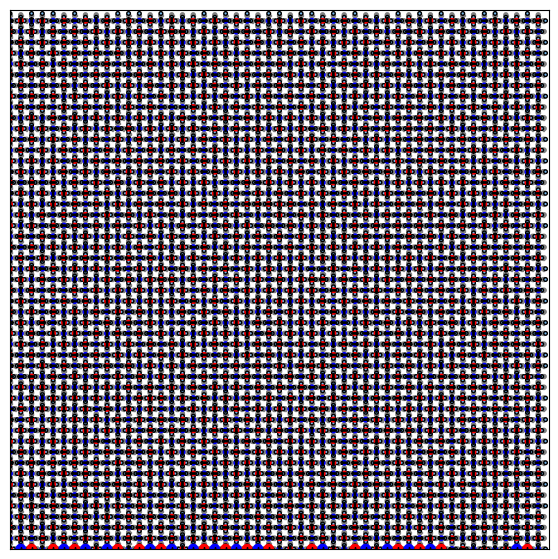

In [144]:
fig, ax= plt.subplots(figsize=(7,7))


region_limit = N*params['lattice_constant'].magnitude
ice.draw_frame(trj, frame_no=0,
               region=[0,region_limit,0,region_limit],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

mc.display_vertices(trj,N,a,ax)
mc.display_arrows(trj,N,a,ax)
#mc.display_lines(trj,N,a,ax)

plt.show()

# Magnetic Structure Factor


In [145]:
def reciprocal_space(N,a):
    kx = 2*np.pi*np.fft.fftshift( np.fft.fftfreq(N,d=a) )
    ky = 2*np.pi*np.fft.fftshift( np.fft.fftfreq(N,d=a) ) 

    KX, KY = np.meshgrid(kx,ky)
    N = len(kx)
    reciprocal_space = np.zeros((N,N,2))
    reciprocal_space[:,:,0] = KX
    reciprocal_space[:,:,1] = KY

    return reciprocal_space

def reciprocal_space_nc(N,a):
    kx = np.linspace(-0.3,0.3,120)
    ky = np.linspace(-0.3,0.3,120)

    KX, KY = np.meshgrid(kx,ky)
    N = len(kx)
    reciprocal_space = np.zeros((N,N,2))
    reciprocal_space[:,:,0] = KX
    reciprocal_space[:,:,1] = KY

    return reciprocal_space


In [146]:
centers, dirs, rels = mc.trj2numpy(trj)
vrt_lattice = mc.create_lattice(a.magnitude,N,spos=(0,0))
indices_matrix = mc.indices_lattice(vrt_lattice,centers,a.magnitude,N)
reciprocal_lattice = reciprocal_space_nc(N,a.magnitude)


In [147]:
rs_indices = np.array([[i,j] for i in range(reciprocal_lattice.shape[0]) for j in range(reciprocal_lattice.shape[1])])
with ProgressBar(total=len(rs_indices)) as progress:
    msf = mc.magnetic_structure_factor(
        centers,
        dirs,
        rels,
        N,
        a.magnitude,
        reciprocal_lattice,
        rs_indices,
        progress)

  0%|          | 0/14400 [00:00<?, ?it/s]

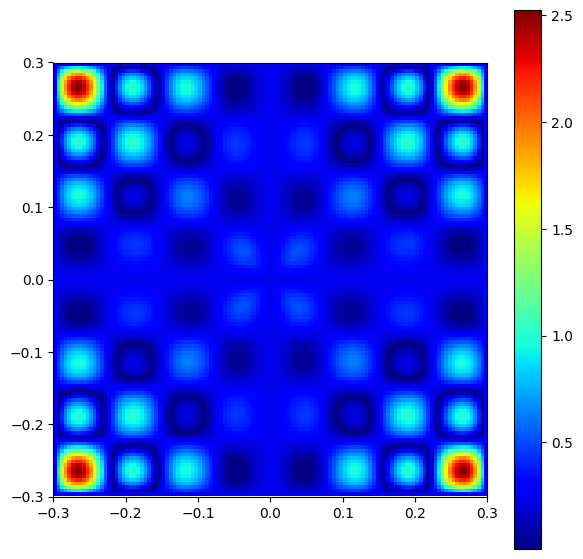

In [140]:
kedge = max(reciprocal_lattice[0,:,0])
fig, ax = plt.subplots(figsize=(7,7))
image = ax.imshow(np.abs(msf), cmap='jet' ,origin='lower',extent=[-kedge,kedge,-kedge,kedge])
fig.colorbar(image)

plt.show()

# old desmadre, favor de no ver

In [93]:
centers, dirs, rels = mc.trj2numpy(trj)
vrt_lattice = mc.create_lattice(a.magnitude,N,spos=(0,0))
indices_matrix = mc.indices_lattice(vrt_lattice,centers,a.magnitude,N)
arrow_lattice = mc.dipole_lattice(centers,dirs,rels, vrt_lattice, indices_matrix)
reciprocal_lattice = reciprocal_space(N,a.magnitude)

In [94]:
pairwise_indices = np.array([[i,j] for i in range(N) for j in range(N)])
rs_indices = np.array([[i,j] for i in range(reciprocal_lattice.shape[0]) for j in range(reciprocal_lattice.shape[1])])

with ProgressBar(total=len(rs_indices)) as progress:
    msf = mc.magnetic_structure_factor(
        reciprocal_lattice,
        arrow_lattice,
        vrt_lattice,
        N,
        a.magnitude,
        pairwise_indices,
        rs_indices,
        progress)

  0%|          | 0/400 [00:00<?, ?it/s]

# spin correlations

In [61]:
df_data = pd.DataFrame(data, columns=['spin1','spin2','dot','distance'])
df_data['distance'] = df_data['distance'].round(3)


In [67]:
grouped_data = []
for d,dfi in df_data.groupby('distance'):
    av_corr = np.mean(dfi['dot'])
    grouped_data.append([d,av_corr])

grouped_data = np.array(grouped_data)

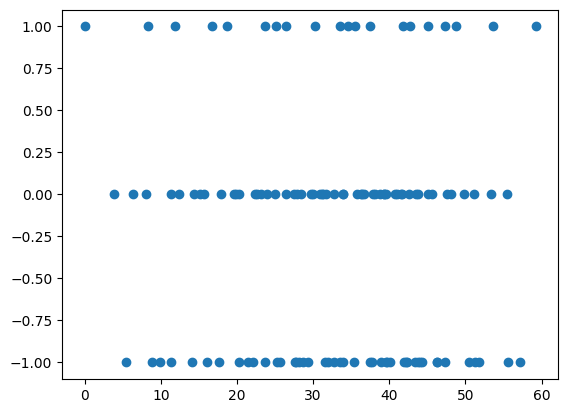

In [68]:
plt.scatter(grouped_data[:,0],grouped_data[:,1])

# dump

In [ ]:
@jit(nopython=True)
def single_point_msf_dipole_lattice(q,arrow_lattice,vrt_lattice,N,a,base_pairs):

    suma = 0 # initialize
    
    # loop through all spin pairs
    for i in range(len(base_pairs)):
        for j in range(i,len(base_pairs)):
            
            ia = base_pairs[i]
            jb = base_pairs[j]

            Sia = arrow_lattice[ia[0],ia[1],:2]
            Sib = arrow_lattice[jb[0],jb[1],:2]

            Sia_perp = perp_diff_spin(Sia,q)
            Sjb_perp = perp_diff_spin(Sib,q)

            ria = vrt_lattice[ia[0],ia[1],:2]
            rjb = vrt_lattice[jb[0],jb[1],:2]

            # just be careful with this displacement...
            # not sure if it is correct, i tried to consideer PBC
            riajb = numba_pbc_displacement(ria,rjb, N*a)[:2]

            term = dotp(Sia_perp,Sjb_perp) * np.exp( 1j * dotp(q,riajb)  )

            # these are pretty much real
            suma = suma + term.real

    return suma/N


@jit(nopython=True, parallel=True)
def magnetic_structure_factor(reciprocal_lattice,arrow_lattice,vrt_lattice,N,a,base_pairs,rc_pairs, progress_proxy):

    rows, cols = reciprocal_lattice.shape[:2]
    msf = np.zeros((rows,cols))

    for j in prange(len(rc_pairs)):

        idx = rc_pairs[j]
        q = reciprocal_lattice[idx[0],idx[1],:]
        msf[idx[0],idx[1]] = single_point_msf_dipole_lattice(q,arrow_lattice, vrt_lattice, N, a, base_pairs)

        progress_proxy.update(1)


    return msf

In [ ]:
def dipole_correlate(arrow_lattice,vrt_lattice, reference = (0,0)):
    
    rows, cols = arrow_lattice.shape[:2]
    correlations_lattice = np.zeros((rows,cols))
    
    dip_ref = arrow_lattice[reference]
    
    for i in range(rows):
        for j in range(cols):

            correlations_lattice[i,j]=np.dot(dip_ref,arrow_lattice[i,j])
    
    return correlations_lattice

# idk try to ignore this
@jit(nopython=True)
def spin_spin_correlate(centers,dirs,rels,a,N,data_length):
    
    L = N*a
    # loop thorugh all the pairs
    number_particles = len(dirs)
    correlations = np.zeros((data_length,4))

    idx = 0 # initialize
    for i in range(number_particles):
        for j in range(i,number_particles):

            Si = dirs[i]
            Sj = dirs[j]
            # absolute positions
            xi = centers[i] + rels[i]
            xj = centers[j] + rels[j]
            # spins and distance
            SiSj = Si[0]*Sj[0] + Si[1]*Sj[1] + Si[2]*Sj[2]
            distance_pbc = numba_pbc_distance(xi,xj,L)

            correlations[idx,:] = np.array([i,j,SiSj,distance_pbc])

            idx= idx + 1

    return correlations
